<a href="https://colab.research.google.com/github/s110/CollabNotebooks/blob/main/Maestria/MachineLearning/Maestr%C3%ADa_Hard_SVM_2024_21ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Practice  Hard SVM.
 ----
  
  University : UTEC \\
  Course       : Machine Learning \\
  Professor    : Cristian López Del Alamo \\
  Topic        : Hard SVM \\
  Termina      : 12:45
   

 ----

Write the names and surnames of the members and the percentage of participation of each one in the development of the practice:
 - Integrante 1: (%)
 - Integrante 2: (%)
 - Integrante 3: (%)
 - Integrante 4: (%)


 ----


  



In [32]:
# Loading libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxopt
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Lagrange Multipliers

$\frac{\partial f(x)}{ \partial x} = λ \frac{\partial g(  x)}{ \partial x}$

----
Find the values of  $λ_i$ for each training elements $X_i$.

The  ***GetLambda*** function returns a vector that we will call  lambda, such that   $lambda[i]$ will be  $0$, if the element  $X[i]$ does not intersect with any of the lines   $XW^t + b >=1$ o $XW^t + b >=0$

Note: X is a matrix, so $X_i$ will be a  $K$-dimensional vector that represent the  i-th  object or  $k$-dimensional point, and  $X_{ij}$ is  the  j-th  element of the  i-th objet.

----


- **Note: The code for finding the lambda values is provided to you.**

In [46]:
import numpy as np
from cvxopt import matrix, solvers

def GetLambda(X, y):
    n, m = X.shape
    y = y.astype(float)
    y_col = y.reshape(-1, 1)
    K = np.dot(X, X.T) * np.dot(y_col, y_col.T)  # Kernel
    P = matrix(K)
    q = matrix(-np.ones(n))
    G = matrix(-np.eye(n))
    h = matrix(np.zeros(n))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    sol = solvers.qp(P, q, G, h, A, b)
    alpha = np.array(sol['x'])
    return alpha

#Ejemplo para utilizar esta función
#lamda = GetLambda(X,Y)
#sv = lamda > 1e-5
#print(sv)

## 2 Calculation of the Weights W
$W_j = \sum_{i=0}^n \lambda_iy_ix_{ij}$  

----
Where: $λ_i$ represent  $i-th$ lagrange multiplier, $W_j$ is the $j-th$ weight,   $x_{ij}$ denotes the value of feacture $(j)$ for the $(i)-th$ training objetc, and $y_i$ is the expected output (1 or -1) for the $i-th$ object.

$W_j = \sum_{i=0}^n \lambda_iy_ix_{ij}$  
Note that the summation only includes elements for which the Lagrange

----

multiplier $lamnda_i$ is nonzero.



In [34]:
import numpy as np

def Get_W(X, Y, lambda_list):
  """
  Calcula el vector de pesos W para un SVM lineal.

  Args:
    X (np.ndarray): Matriz de datos de entrenamiento, donde cada fila es una
                    muestra y cada columna es una característica.
                    Dimensiones: (n_samples, n_features).
    Y (np.ndarray): Vector de etiquetas de clase (1 o -1) para cada muestra.
                    Dimensiones: (n_samples,) o (n_samples, 1).
    lambda_list (np.ndarray): Vector de multiplicadores de Lagrange.
                              Dimensiones: (n_samples,) o (n_samples, 1).

  Returns:
    np.ndarray: El vector de pesos W. Dimensiones: (n_features,).
  """
  # Asegurarse de que lambda_list y Y sean arrays 1D para cálculos consistentes.
  # La salida de GetLambda (sol['x']) es una matriz cvxopt, luego convertida a np.array,
  # que probablemente tiene forma (n_samples, 1). Usamos flatten().
  # Y también podría ser (n_samples,) o (n_samples, 1).
  lambda_flat = lambda_list.flatten()
  Y_flat = Y.flatten()

  # n_samples, n_features = X.shape # No es estrictamente necesario aquí

  # La fórmula es W_j = sum_i (lambda_i * y_i * x_ij)
  # Esto se puede vectorizar como W = X^T @ (lambda * y)

  # 1. Calcular el término (lambda_i * y_i) para cada muestra.
  # Este término pondera la contribución de cada muestra.
  # Si lambda_i es cercano a 0 (vector no de soporte), su contribución es mínima.
  weighted_terms = lambda_flat * Y_flat

  # 2. Calcular W.
  # W_j = sum_i (weighted_terms_i * X_ij)
  # Esto es equivalente a la transpuesta de X multiplicada por los términos ponderados.
  # X.T tiene dimensiones (n_features, n_samples)
  # weighted_terms tiene dimensiones (n_samples,)
  # El resultado W tendrá dimensiones (n_features,)
  W = np.dot(X.T, weighted_terms)

  return W

## Finding the Bias (b)

$XW^t + b = 0$

$b = - \frac{1}{n}∑_{i=0}^n X_iW^t$

Where $X_i$ is a $k$-dimensional vector representing the $i$-th object, and $k$ is the number of features of the object.



In [35]:
def Get_b(X, W):
  """
  Calcula el término de sesgo b para un SVM lineal usando la fórmula
  b = - (1/n) * sum(X_i @ W).

  Args:
    X (np.ndarray): Matriz de datos de entrenamiento, donde cada fila es una
                    muestra y cada columna es una característica.
                    Dimensiones: (n_samples, n_features).
    W (np.ndarray): Vector de pesos W. Asumimos que es un array 1D.
                    Dimensiones: (n_features,).

  Returns:
    float: El término de sesgo b.
  """
  # n_samples es el número de filas en X
  n_samples = X.shape[0]

  # W es un vector 1D (n_features,).
  # X es una matriz (n_samples, n_features).
  # np.dot(X, W) calcula el producto punto de cada fila de X con W.
  # El resultado es un array 1D de longitud n_samples, donde cada
  # elemento es X_i @ W^T (o X_i · W).
  # Ejemplo:
  # X = [[x11, x12], [x21, x22]]
  # W = [w1, w2]
  # np.dot(X, W) = [x11*w1 + x12*w2, x21*w1 + x22*w2]
  xw_products = np.dot(X, W)

  # Sumamos todos estos productos punto
  sum_xw_products = np.sum(xw_products)

  # Calculamos el promedio de los productos punto
  mean_xw_products = sum_xw_products / n_samples

  # b es el negativo de este promedio
  b = -mean_xw_products

  return b

## Testing Stage

----
For this stage, one should only calculate :

- $f(X_j) = X_jW^t + b$

But since we have already calculated the values of the parameters $W$ and  $b$, then by substituting we have :

- $f(X_j) = \sum_{i=0}^n \lambda_iy_i<X_{i},X_{j}> + b$

Donde: $X_i$ is the i-th  training vector and  $X_j$   is the new vector that passes through the model for predicting the class (1 or -1)

Finally, to determine which class the new vector $X_j$   belongs to, it is sufficient to check the sign of f(X_j).

  - **If $f(X_j) >=0$ then $Y_j$ = 1 else $Y_j = -1$**
  -----

In [36]:
def Test(X_new, W, b):
  """
  Predice las etiquetas de clase para nuevas muestras utilizando un modelo SVM lineal
  previamente entrenado (con W y b conocidos).

  Args:
    X_new (np.ndarray): Matriz de nuevas muestras a clasificar.
                        Cada fila es una muestra, cada columna es una característica.
                        Dimensiones: (n_new_samples, n_features).
    W (np.ndarray): Vector de pesos del SVM.
                    Asumimos que es un array 1D.
                    Dimensiones: (n_features,).
    b (float): Término de sesgo del SVM.

  Returns:
    np.ndarray: Un vector de etiquetas de clase predichas (1 o -1)
                para cada muestra en X_new.
                Dimensiones: (n_new_samples,).
  """
  # Calcular la función de decisión para cada muestra en X_new:
  # f(X_j) = X_j @ W + b
  # np.dot(X_new, W) calcula el producto punto de cada fila de X_new con W.
  # Si X_new es (m, k) y W es (k,), el resultado es (m,).
  decision_scores = np.dot(X_new, W) + b

  # Aplicar la regla de clasificación:
  # Si f(X_j) >= 0, entonces Y_j = 1
  # Si f(X_j) < 0, entonces Y_j = -1
  # La función np.where es ideal para esto.
  predictions = np.where(decision_scores >= 0, 1, -1)

  return predictions

Database for Testing:
[Download](https://docs.google.com/spreadsheets/d/15-E3kiLJ6bCyXuJvSmxYAp2QYMkPX2QlQ597fAsPYy8/edit#gid=0).

----
Download the database to your disk and use files.upload() to load it onto the drive. The code is provided.
----


- Split the dataset into 70% for training and 30% for testing.
- Add a value of 1 for the first class and -1 for the second class.
- In the testing stage, find the number of elements correctly classified and the number of elements incorrectly classified for each class

- Create a [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) which will show us the efficiency of the method.

- Do not forget to normalize the data.

- Plot the lines that separate both classes.

----


In [49]:
# code for loading  the Dataset
import pandas as pd
import numpy as np

url='https://github.com/s110/CollabNotebooks/raw/refs/heads/main/Maestria/MachineLearning/SMV/DataSet_Iris_2_Clases.csv'

data = pd.read_csv(url,sep=';')

X_df = data[["sepal.length","sepal.width","petal.length","petal.width"]]
Y_df = data[["variety"]]
print(X_df)

# Splitting the dataset into training and testing

from sklearn.model_selection import train_test_split


# --- 1. Conversión de Etiquetas ---
# Identificar las clases únicas
unique_classes = Y_df['variety'].unique()
if len(unique_classes) != 2:
    raise ValueError("Se esperan exactamente dos clases para este SVM binario.")

# Mapear la primera clase a 1 y la segunda a -1
class_mapping = {unique_classes[0]: 1, unique_classes[1]: -1}
Y_numeric = Y_df['variety'].map(class_mapping).values # .values para obtener un array NumPy

# --- División del Dataset ---
# (Ya lo tenías, solo asegurándonos de usar Y_numeric)
X_train_df, X_test_df, Y_train, Y_test = train_test_split(
    X_df, Y_numeric, random_state=104, test_size=0.30, shuffle=True
)

# Convertir DataFrames de X a arrays NumPy para las funciones SVM
X_train = X_train_df.values
X_test = X_test_df.values

print("Forma de X_train:", X_train.shape)
print("Forma de Y_train:", Y_train.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de Y_test:", Y_test.shape)
print("Clases únicas en Y_train:", np.unique(Y_train))
print("Clases únicas en Y_test:", np.unique(Y_test))

    sepal.length  sepal.width  petal.length  petal.width
0            5.1          3.5           1.4          0.2
1            4.9          3.0           1.4          0.2
2            4.7          3.2           1.3          0.2
3            4.6          3.1           1.5          0.2
4            5.0          3.6           1.4          0.2
..           ...          ...           ...          ...
95           5.7          3.0           4.2          1.2
96           5.7          2.9           4.2          1.3
97           6.2          2.9           4.3          1.3
98           5.1          2.5           3.0          1.1
99           5.7          2.8           4.1          1.3

[100 rows x 4 columns]
Forma de X_train: (70, 4)
Forma de Y_train: (70,)
Forma de X_test: (30, 4)
Forma de Y_test: (30,)
Clases únicas en Y_train: [-1  1]
Clases únicas en Y_test: [-1  1]


     pcost       dcost       gap    pres   dres
 0: -2.1616e+00 -3.7014e+00  1e+02  1e+01  1e+00
 1: -3.9314e-01 -1.5104e+00  8e+00  6e-01  8e-02
 2: -1.6945e-01 -9.6670e-01  8e-01  1e-16  9e-15
 3: -3.6981e-01 -5.5491e-01  2e-01  6e-17  4e-15
 4: -4.6037e-01 -5.7986e-01  1e-01  1e-16  4e-15
 5: -5.2366e-01 -5.3509e-01  1e-02  1e-16  4e-15
 6: -5.3196e-01 -5.3210e-01  1e-04  5e-17  4e-15
 7: -5.3207e-01 -5.3207e-01  1e-06  7e-17  4e-15
 8: -5.3207e-01 -5.3207e-01  1e-08  7e-17  4e-15
Optimal solution found.


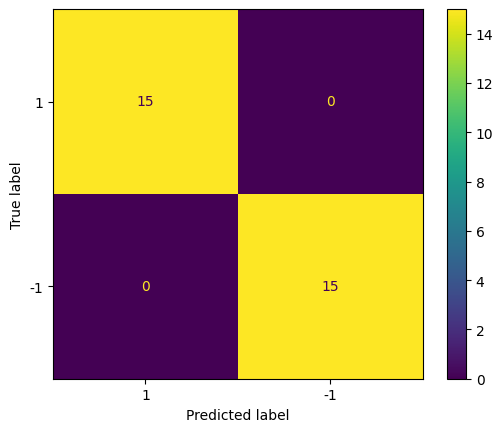

In [52]:
# Obtaining the values of the parameters W and b, to predict the classes to which the values of X_test belong

lambda_list=GetLambda(X_train, Y_train)
W =  Get_W(X_train,Y_train,lambda_list)
b =  Get_b(X_train,W)

# Convert all values greater than 0 to 1, and those less than 0 to -1
Y_pred  = np.sign(Test(X_test,W,b))

# We create a confution matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, -1])
cm_display.plot()
plt.show()


----

- Subir el link de su colab a canvas
- Disfruten aprendiendo. La única forma de aprender es haciendo.
- Buena Suerte.
----


Primeras 2 filas de X_train normalizado:
 [[ 1.03971245 -0.17508023  1.20363017  1.0967791 ]
 [-0.52208737  1.38472548 -0.95138424 -0.6763049 ]]
Media de X_train_normalized (debería ser cercana a 0): [-1.18952467e-15 -3.71131697e-16  1.15780401e-16  1.04678171e-16]
Std de X_train_normalized (debería ser cercana a 1): [1. 1. 1. 1.]

Entrenando el modelo SVM...
     pcost       dcost       gap    pres   dres
 0: -2.1816e+00 -3.6160e+00  1e+02  1e+01  1e+00
 1: -5.2604e-01 -1.3391e+00  1e+01  8e-01  1e-01
 2: -1.1901e-01 -8.9195e-01  8e-01  2e-16  6e-16
 3: -3.4787e-01 -5.7000e-01  2e-01  9e-17  4e-16
 4: -4.8540e-01 -5.3575e-01  5e-02  6e-17  3e-16
 5: -5.1148e-01 -5.3353e-01  2e-02  2e-16  3e-16
 6: -5.2747e-01 -5.2909e-01  2e-03  2e-16  4e-16
 7: -5.2876e-01 -5.2881e-01  5e-05  1e-16  5e-16
 8: -5.2880e-01 -5.2880e-01  5e-07  2e-16  5e-16
Optimal solution found.
Forma de lambda_values: (70, 1)
Vector de pesos W: [-0.32641071  0.27152156 -0.71457847 -0.60556692]
Forma de W_vector: (4,)

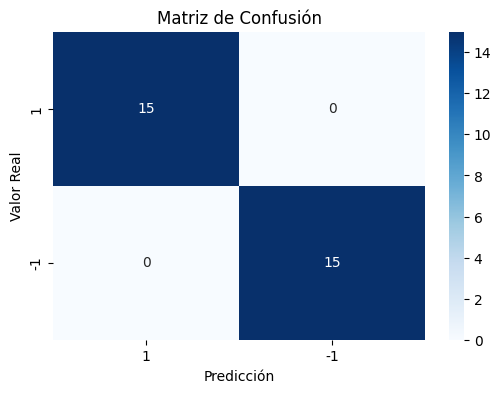

In [55]:
from sklearn.preprocessing import StandardScaler
# --- 2. Normalización de Características ---
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test) # Usar el mismo scaler ajustado en train

print("\nPrimeras 2 filas de X_train normalizado:\n", X_train_normalized[:2])
print("Media de X_train_normalized (debería ser cercana a 0):", np.mean(X_train_normalized, axis=0))
print("Std de X_train_normalized (debería ser cercana a 1):", np.std(X_train_normalized, axis=0))

# --- 3. Entrenamiento del Modelo SVM ---
print("\nEntrenando el modelo SVM...")
# Asegurarse de que Y_train sea un vector columna para GetLambda si es necesario
# o ajustar GetLambda para que maneje Y 1D correctamente.
# La implementación actual de GetLambda espera y.reshape(1,-1) para A,
# y y.astype(float) para el cálculo de K. Y_train ya es 1D.
lambda_values = GetLambda(X_train_normalized, Y_train)
print("Forma de lambda_values:", lambda_values.shape)

W_vector = Get_W(X_train_normalized, Y_train, lambda_values)
print("Vector de pesos W:", W_vector)
print("Forma de W_vector:", W_vector.shape)

# Para Get_b, la fórmula que usamos es b = - (1/n) * sum(X_i @ W)
# Alternativamente, b se puede calcular usando vectores de soporte.
# b_offset = Get_b(X_train_normalized, W_vector)

# Cálculo de b usando vectores de soporte (más robusto para SVM)
# Identificar vectores de soporte (aquellos con lambda > umbral pequeño)
support_vector_indices = np.where(lambda_values.flatten() > 1e-5)[0]
if len(support_vector_indices) == 0:
    print("Advertencia: No se encontraron vectores de soporte. El modelo puede no haber convergido bien.")
    # Fallback a la media si no hay SVs (aunque esto es inusual)
    b_offset = Get_b(X_train_normalized, W_vector)
else:
    # Calcular b para cada vector de soporte y promediar
    # b = y_s - X_s @ W
    b_values_sv = Y_train[support_vector_indices] - np.dot(X_train_normalized[support_vector_indices], W_vector)
    b_offset = np.mean(b_values_sv)

print("Término de sesgo b:", b_offset)


# --- 4. Prueba del Modelo ---
print("\nProbando el modelo...")
Y_pred = Test(X_test_normalized, W_vector, b_offset)
print("Predicciones (primeros 10):", Y_pred[:10])
print("Valores reales (primeros 10):", Y_test[:10])

# --- 5. Evaluación del Modelo ---
print("\nEvaluación del modelo:")
correct_predictions = np.sum(Y_pred == Y_test)
total_predictions = len(Y_test)
accuracy = correct_predictions / total_predictions
print(f"Precisión (Accuracy): {accuracy:.4f}")

# Elementos correctamente e incorrectamente clasificados por clase
for cls_val in np.unique(Y_test):
    cls_mask_test = (Y_test == cls_val)
    cls_mask_pred = (Y_pred == cls_val)

    correctly_classified = np.sum(cls_mask_test & cls_mask_pred)
    # Incorrectamente clasificados para esta clase verdadera:
    # Son aquellos donde Y_test es cls_val PERO Y_pred NO es cls_val
    incorrectly_classified = np.sum(cls_mask_test & ~cls_mask_pred)

    print(f"Clase {int(cls_val)}:")
    print(f"  Correctamente clasificados: {correctly_classified}")
    print(f"  Incorrectamente clasificados: {incorrectly_classified}")

# Matriz de Confusión
cm = metrics.confusion_matrix(Y_test, Y_pred)
print("\nMatriz de Confusión:")
print(cm)

# Para una mejor visualización de la matriz de confusión
import seaborn as sns # Opcional, para una gráfica más bonita

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_mapping.keys(), # O [1, -1] si prefieres
            yticklabels=class_mapping.keys()) # O [1, -1] si prefieres
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

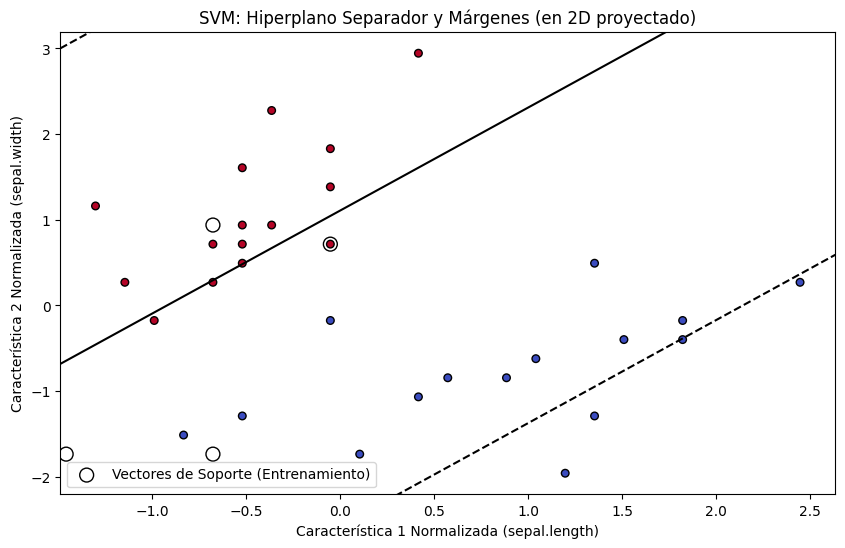

In [60]:
# --- 6. Visualización del Hiperplano Separador (en 2D) ---
# Solo podemos graficar en 2D. Elegiremos las dos primeras características normalizadas.
# Esto es una simplificación. El hiperplano real existe en 4D.

if X_train_normalized.shape[1] >= 2: # Si tenemos al menos 2 características
    X_vis = X_test_normalized[:, :2] # Usar las dos primeras características para visualización
    W_vis = W_vector[:2]             # Pesos correspondientes a esas dos características
    # Para la línea de decisión: x1*w1 + x2*w2 + (x3*w3 + x4*w4)_avg + b = 0
    # Si solo usamos w1, w2, b, estamos proyectando.
    # Una forma más simple para la visualización 2D es considerar solo las 2D features
    # y el hiperplano en ese subespacio: x_vis_1*w_vis_1 + x_vis_2*w_vis_2 + b_offset = 0
    # Entonces, x_vis_2 = (-b_offset - x_vis_1*w_vis_1) / w_vis_2

    plt.figure(figsize=(10, 6))
    # Graficar los puntos de prueba
    scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=Y_test, cmap=plt.cm.coolwarm, s=30, edgecolors='k')
    plt.xlabel(f'Característica 1 Normalizada ({X_df.columns[0]})')
    plt.ylabel(f'Característica 2 Normalizada ({X_df.columns[1]})')
    plt.title('SVM: Hiperplano Separador y Márgenes (en 2D proyectado)')

    # Crear un grid para graficar el hiperplano
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 50)
    yy = np.linspace(ylim[0], ylim[1], 50)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T # Puntos del grid

    # Para graficar la línea de decisión en el espacio 2D de las características seleccionadas,
    # necesitamos considerar el efecto de las otras dimensiones si W_vector tiene más de 2 elementos.
    # Una aproximación es asumir que las otras características están en su media (0 después de normalizar)
    # Z = w1*x1 + w2*x2 + w3*x3_mean + w4*x4_mean + b
    # Si x3_mean y x4_mean son 0 (por normalización), entonces Z = w1*x1 + w2*x2 + b
    # Esto es si W_vis solo toma los primeros dos componentes de W_vector.
    # Si W_vector tiene más de 2 componentes, la línea de decisión en el plano (x1,x2)
    # es (W[0]*x1 + W[1]*x2 + sum(W[k]*mean(X_train_norm[:,k])) + b = 0)
    # Como mean(X_train_norm[:,k]) es 0 para k>=2:
    # W[0]*x1 + W[1]*x2 + b = 0
    # x2 = (-b - W[0]*x1) / W[1]

    if W_vis.shape[0] == 2 and W_vis[1] != 0: # Asegurarse de que W_vis[1] no sea cero
        # Línea de decisión: w0*x + w1*y + b = 0 => y = (-b - w0*x) / w1
        a = -W_vis[0] / W_vis[1]
        line_y = a * xx - (b_offset / W_vis[1])
        plt.plot(xx, line_y, 'k-')
        # Márgenes: y = a*xx - (b_offset +/- 1) / w1
        plt.plot(xx, line_y - 1 / W_vis[1], 'k--')
        plt.plot(xx, line_y + 1 / W_vis[1], 'k--')

        # Resaltar vectores de soporte si los hubiera en el conjunto de prueba (más complejo de visualizar directamente aquí)
        # Los vectores de soporte originales están en X_train_normalized.
        # Podríamos graficar X_train_normalized también.
        sv_indices_train = np.where(lambda_values.flatten() > 1e-5)[0]
        if len(sv_indices_train) > 0:
            plt.scatter(X_train_normalized[sv_indices_train, 0], X_train_normalized[sv_indices_train, 1],
                        s=100, facecolors='none', edgecolors='k', label='Vectores de Soporte (Entrenamiento)')
        plt.legend()
    else:
        print("No se puede graficar la línea de decisión en 2D con los pesos actuales (W_vis[1] podría ser 0 o W_vis no tiene 2 elementos).")

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()
else:
    print("No hay suficientes características para la visualización 2D.")